## Assignment 8
### GTECH 731
### Spring 2023
### Jake Markey

Import necessary packages and data

In [1]:
import geopandas as gpd
import pandas as pd
import json

county_df = gpd.read_file("gz_2010_us_050_00_5m.json")


Find top n most common county names (n = 3 or 5, for example)

In [2]:
#Write the top 3 counties to a dataframe. 
#The methods passed to county_df could simply be printed, but we'll want to access them again in the last part of this lab.
top3 = pd.DataFrame(county_df['NAME'].value_counts().head(3))
top3 = top3.reset_index()
top3.columns = ['Top3_CountyNames', 'Count']
print(top3)

  Top3_CountyNames  Count
0       Washington     31
1         Franklin     26
2        Jefferson     26


Join fips code to get full names of states (please do a real join using merge)

In [3]:
#Read json file to State_Codes variable
with open("fipsToState.json", 'r') as f:
    State_Codes = json.load(f)

#Store State_Codes as a dataframe
statecode_df =  pd.DataFrame(list(State_Codes.items()), columns=['FIPs', 'State_Name'])

#Join FIPs codes so primary, county_df geodataframe includes state names
county_df =  pd.merge(county_df, statecode_df, left_on='STATE', right_on='FIPs')

print(county_df.head(5))

           GEO_ID STATE COUNTY            NAME     LSAD  CENSUSAREA  \
0  0500000US02261    02    261  Valdez-Cordova       CA   34239.880   
1  0500000US02270    02    270    Wade Hampton       CA   17081.433   
2  0500000US02275    02    275        Wrangell  Cty&Bor    2541.483   
3  0500000US02290    02    290   Yukon-Koyukuk       CA  145504.789   
4  0500000US02013    02    013  Aleutians East  Borough    6981.943   

                                            geometry FIPs State_Name  
0  MULTIPOLYGON (((-147.48383 60.61864, -147.5000...   02     Alaska  
1  POLYGON ((-162.58775 63.27573, -162.55188 63.2...   02     Alaska  
2  MULTIPOLYGON (((-132.56988 56.63350, -132.5703...   02     Alaska  
3  POLYGON ((-141.00247 65.83942, -141.09244 65.8...   02     Alaska  
4  MULTIPOLYGON (((-166.10574 53.98861, -166.0752...   02     Alaska  


Derive summary statistics for states, for example, number of counties, counties with max/min area

In [4]:
# Group by state and aggregate the number of counties, max/min CENSUSAREA, and corresponding county names
state_summary = county_df.groupby('State_Name').agg({
    'NAME': ['count'],
    'CENSUSAREA': ['idxmax', 'max', 'idxmin', 'min']
}).reset_index()

# Get the largest and smallest county names using the indices obtained above
state_summary[('largest_county', '')] = county_df.loc[state_summary[('CENSUSAREA', 'idxmax')]]['NAME'].values
state_summary[('smallest_county', '')] = county_df.loc[state_summary[('CENSUSAREA', 'idxmin')]]['NAME'].values

# Rename the columns
state_summary = state_summary.drop([('CENSUSAREA', 'idxmax'), ('CENSUSAREA', 'idxmin')], axis=1)
state_summary.columns = ['state', 'number_of_counties', 'largest_county_area', 'smallest_county_area', 'largest_county', 'smallest_county']

print(state_summary.head(5))


        state  number_of_counties  largest_county_area  smallest_county_area  \
0     Alabama                  67             1589.784               534.991   
1      Alaska                  29           145504.789               452.325   
2     Arizona                  15            18618.885              1236.916   
3    Arkansas                  75             1039.214               528.268   
4  California                  58            20056.938                46.873   

   largest_county smallest_county  
0         Baldwin          Etowah  
1   Yukon-Koyukuk         Skagway  
2        Coconino      Santa Cruz  
3           Union       Lafayette  
4  San Bernardino   San Francisco  


Plot maps to show all the counties with the most common names from first task. First, create the necessary geodataframes.

In [5]:
#Create 3 geodataframes that only contain the counties with a top 3 most common name 
top3county_list = top3['Top3_CountyNames'].tolist()

# Initialize an empty dictionary to store the new GeoDataFrames
top3_county_gdfs = {}

# Loop through the names in top3county_list
for county_name in top3county_list:
    # Query the county_df GeoDataFrame for rows with a matching value in the 'NAME' column
    matching_rows = county_df.query("NAME == @county_name")

    # Write the matching rows to a new GeoDataFrame and store it in the dictionary
    top3_county_gdfs[county_name] = gpd.GeoDataFrame(matching_rows)

#Write the dictionary values to standalone geodataframes
washington = top3_county_gdfs["Washington"]["geometry"]
jefferson = top3_county_gdfs["Jefferson"]["geometry"]
franklin = top3_county_gdfs["Franklin"]["geometry"]


Finally, plot all three geodataframes together and save the result as a png file. 

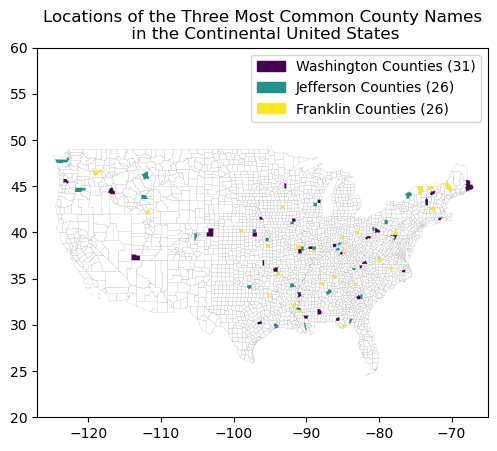

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Create a sequential color scheme to visually connote different values
#Note: this isn't the best use case since the 2nd and 3rd values are tied for frequency count
num_colors = 3
cmap = plt.get_cmap('viridis', 3)
colors = [cmap(i) for i in range(3)]

#Use the county_df geodataframe as a basemap- only show the outline of the county boundaries
base = county_df.plot(linewidth=.1, color='white', edgecolor='grey')
ax = base 

#Add the three most common counties to the map. Visualize with colors from the sequential color scheme
washington.plot(ax=ax, color=colors[0])
jefferson.plot(ax=ax, color=colors[1])
franklin.plot(ax=ax, color=colors[2])

# Use the mpatches module to create legend handles for each county name and add them to the legend
washington_patch = mpatches.Patch(color=colors[0], label="Washington Counties (31)")
jefferson_patch = mpatches.Patch(color=colors[1], label="Jefferson Counties (26)")
franklin_patch = mpatches.Patch(color=colors[2], label="Franklin Counties (26)")
ax.legend(handles=[washington_patch, jefferson_patch, franklin_patch])

#county_df has a large footprint since it includes Guam and other U.S. territories. Instead of limiting the 
#items in the basemap size, we will set custom limits to the plot axes to only show the continental U.S. 
#This way, it is easier to see the data in one map.
ax.set_xlim(-127, -65)
ax.set_ylim(20,60)

#Set title
ax.set_title("Locations of the Three Most Common County Names\n in the Continental United States")

#Save as a png image and show it in the Jupyter notebook
plt.savefig("Top3CountyLocations.png", dpi=300, bbox_inches='tight')
plt.show()